## Anomaly Computation

In [49]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
import sovai as sov

sov.token_auth(token="your_token_here")

### Multivariate Anomaly Detection - Accounting Factors

In [54]:
# Load ratios - takes around 
df_factors = sov.data("factors/accounting", purge_cache=True); df_factors.head()

AttributeError: 'NoneType' object has no attribute 'head'

#### Local, Global, and Cluster Scores (For NVDA)

I only want to look at the last **three years**, the data should be in **percentile format**

In [33]:
import pandas as pd

ticker = "NVDA"

df_last_3_years = df_factors.loc[(slice(None), slice(pd.Timestamp.now() - pd.DateOffset(years=3), None)), :]
df_last_3_years = df_last_3_years.percentile()

df_anomaly_scores = df_last_3_years.anomalies("scores",ticker)

Optimal k for global anomaly detection: 48


In [34]:
df_anomaly_scores.query("ticker =='NVDA'")

global_anomaly_score  local_anomaly_score  \
ticker date                                                    
NVDA   2021-07-09                 0.287                0.233   
       2021-07-16                 0.281                0.208   
       2021-07-23                 0.219                0.093   
       2021-07-30                 0.234                0.078   
       2021-08-06                 0.235                0.085   
...                                 ...                  ...   
       2024-06-07                 0.192                0.161   
       2024-06-14                 0.333                0.534   
       2024-06-21                 0.175                0.167   
       2024-06-28                 0.193                0.221   
       2024-07-05                 0.185                0.151   

                   clustered_anomaly_score  
ticker date                                 
NVDA   2021-07-09                    0.077  
       2021-07-16                    0.007  
       2021-07-23                    0.005  
       2021-07-30                    0.007  
       2021-08-06                    0.008  
...                                    ...  
       2024-06-07                    0.011  
       2024-06-14                    0.270  
       2024-06-21                    0.005  
       2024-06-28                    0.027  
       2024-07-05                    0.021  

[157 rows x 3 columns]

Plotting for random tickers. Specify tickers to plot specific data.


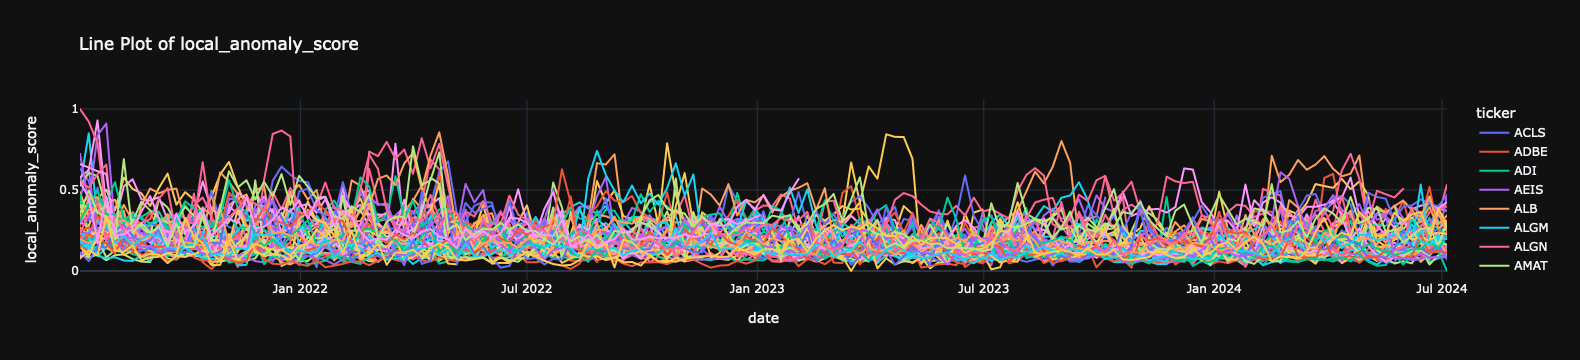

In [35]:
df_anomaly_scores.plot_line("local_anomaly_score", n=50)

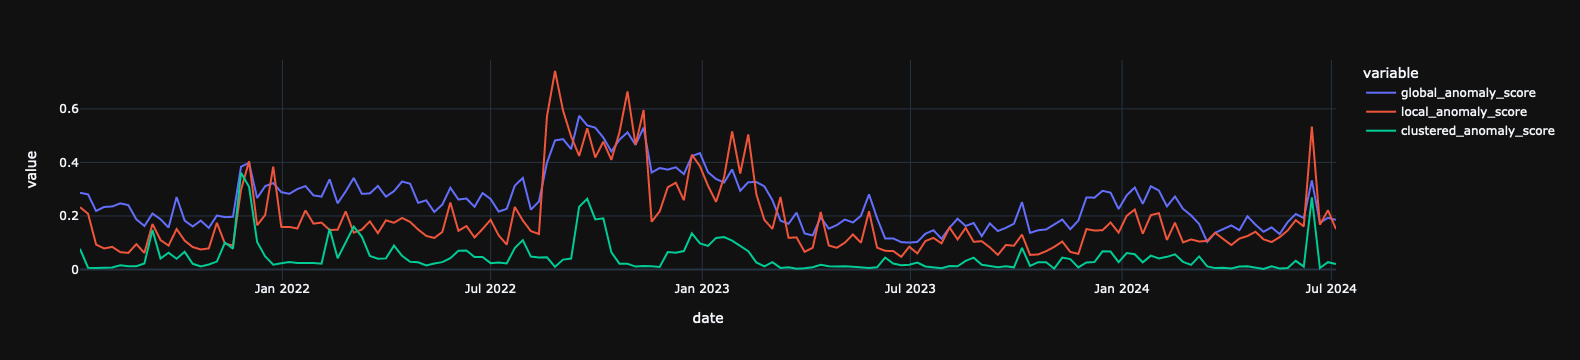

In [36]:
df_anomaly_scores.query("ticker =='NVDA'").reset_index().set_index(["date"]).drop(columns=['ticker']).plot()

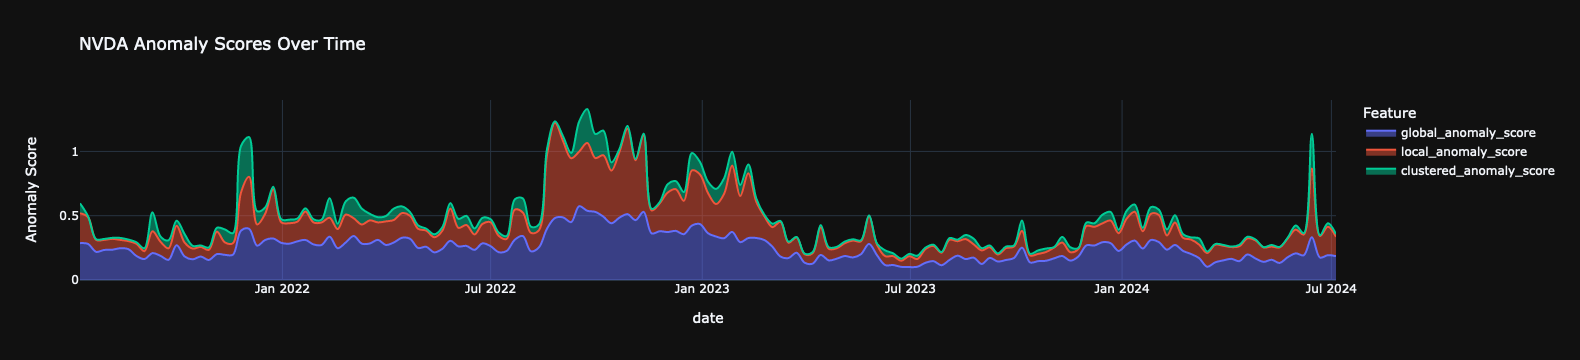

In [37]:
import plotly.express as px

px.area(df_anomaly_scores.query("ticker == 'NVDA'").reset_index().set_index("date").drop(columns=['ticker']), title="NVDA Anomaly Scores Over Time", labels={"value": "Anomaly Score", "variable": "Feature"}, line_shape="spline").show()

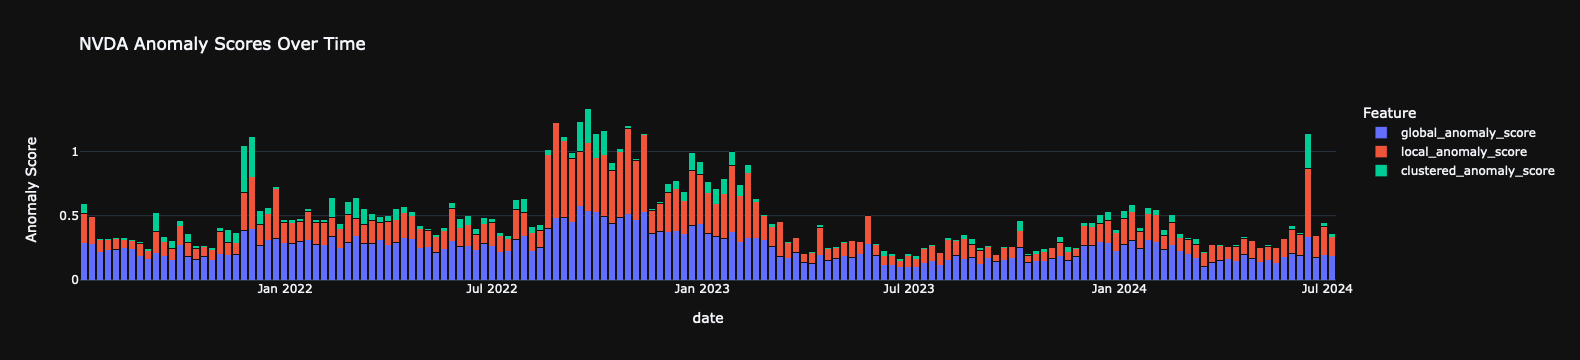

In [38]:
import plotly.express as px

px.bar(df_anomaly_scores.query("ticker == 'NVDA'").reset_index().melt(id_vars=['date', 'ticker'], var_name='Feature', value_name='Anomaly Score'), x='date', y='Anomaly Score', color='Feature', title="NVDA Anomaly Scores Over Time", barmode='stack').show()

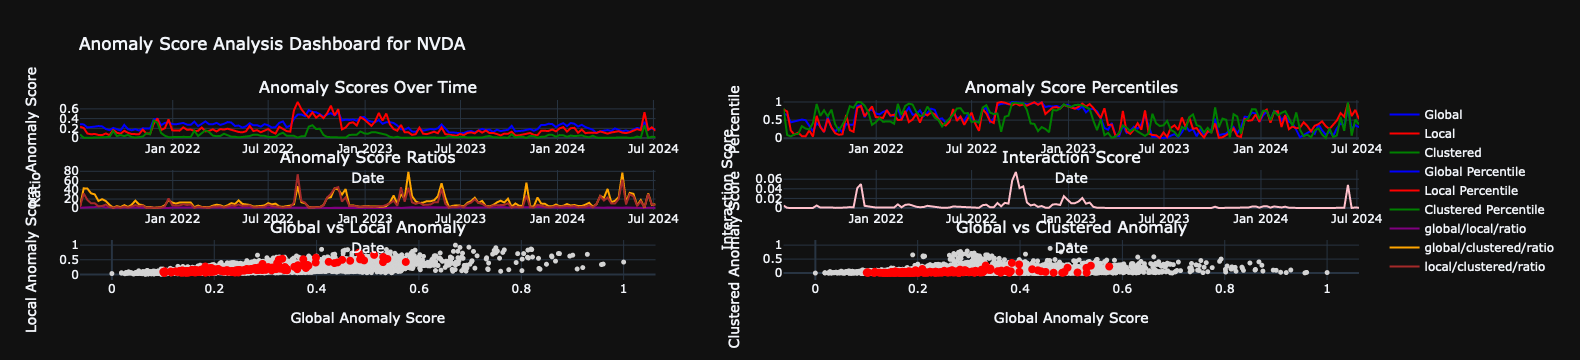

In [39]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import numpy as np

def create_anomaly_dashboard(df_anomaly_scores, ticker):
    # Filter for the specific ticker and calculate percentile ranks
    df_ticker = df_anomaly_scores.loc[ticker].reset_index()
    df_all = df_anomaly_scores.reset_index()
    
    for score in ['global_anomaly_score', 'local_anomaly_score', 'clustered_anomaly_score']:
        df_ticker[f'{score}_percentile'] = df_ticker[score].rank(pct=True)
    
    # Calculate ratios and interactions
    for df in [df_ticker, df_all]:
        df['global_local_ratio'] = df['global_anomaly_score'] / df['local_anomaly_score']
        df['global_clustered_ratio'] = df['global_anomaly_score'] / df['clustered_anomaly_score']
        df['local_clustered_ratio'] = df['local_anomaly_score'] / df['clustered_anomaly_score']
        df['interaction_score'] = df['global_anomaly_score'] * df['local_anomaly_score'] * df['clustered_anomaly_score']
    
    # Create subplots
    fig = make_subplots(rows=3, cols=2, 
                        subplot_titles=('Anomaly Scores Over Time', 'Anomaly Score Percentiles',
                                        'Anomaly Score Ratios', 'Interaction Score',
                                        'Global vs Local Anomaly', 'Global vs Clustered Anomaly'))
    
    # Anomaly Scores Over Time
    for score, color in zip(['global_anomaly_score', 'local_anomaly_score', 'clustered_anomaly_score'], ['blue', 'red', 'green']):
        fig.add_trace(go.Scatter(x=df_ticker['date'], y=df_ticker[score], name=score.split('_')[0].capitalize(), line=dict(color=color)), row=1, col=1)
    
    # Anomaly Score Percentiles
    for score, color in zip(['global_anomaly_score', 'local_anomaly_score', 'clustered_anomaly_score'], ['blue', 'red', 'green']):
        fig.add_trace(go.Scatter(x=df_ticker['date'], y=df_ticker[f'{score}_percentile'], name=f'{score.split("_")[0].capitalize()} Percentile', line=dict(color=color)), row=1, col=2)
    
    # Anomaly Score Ratios
    for ratio, color in zip(['global_local_ratio', 'global_clustered_ratio', 'local_clustered_ratio'], ['purple', 'orange', 'brown']):
        fig.add_trace(go.Scatter(x=df_ticker['date'], y=df_ticker[ratio], name=ratio.replace('_', '/'), line=dict(color=color)), row=2, col=1)
    
    # Interaction Score
    fig.add_trace(go.Scatter(x=df_ticker['date'], y=df_ticker['interaction_score'], name='Interaction', line=dict(color='pink')), row=2, col=2)
    
    # Global vs Local Anomaly
    fig.add_trace(go.Scatter(x=df_all['global_anomaly_score'], y=df_all['local_anomaly_score'], mode='markers', name='All Tickers', marker=dict(color='lightgrey', size=5)), row=3, col=1)
    fig.add_trace(go.Scatter(x=df_ticker['global_anomaly_score'], y=df_ticker['local_anomaly_score'], mode='markers', name=ticker, marker=dict(color='red', size=8)), row=3, col=1)
    
    # Global vs Clustered Anomaly
    fig.add_trace(go.Scatter(x=df_all['global_anomaly_score'], y=df_all['clustered_anomaly_score'], mode='markers', name='All Tickers', marker=dict(color='lightgrey', size=5)), row=3, col=2)
    fig.add_trace(go.Scatter(x=df_ticker['global_anomaly_score'], y=df_ticker['clustered_anomaly_score'], mode='markers', name=ticker, marker=dict(color='red', size=8)), row=3, col=2)
    
    # Update layout
    fig.update_layout(height=1200, title_text=f"Anomaly Score Analysis Dashboard for {ticker}")
    fig.update_xaxes(title_text="Date", row=1, col=1)
    fig.update_xaxes(title_text="Date", row=1, col=2)
    fig.update_xaxes(title_text="Date", row=2, col=1)
    fig.update_xaxes(title_text="Date", row=2, col=2)
    fig.update_xaxes(title_text="Global Anomaly Score", row=3, col=1)
    fig.update_xaxes(title_text="Global Anomaly Score", row=3, col=2)
    fig.update_yaxes(title_text="Anomaly Score", row=1, col=1)
    fig.update_yaxes(title_text="Percentile", row=1, col=2)
    fig.update_yaxes(title_text="Ratio", row=2, col=1)
    fig.update_yaxes(title_text="Interaction Score", row=2, col=2)
    fig.update_yaxes(title_text="Local Anomaly Score", row=3, col=1)
    fig.update_yaxes(title_text="Clustered Anomaly Score", row=3, col=2)
    
    return fig

# Usage
ticker = "NVDA"  # or any other ticker in your dataset
fig = create_anomaly_dashboard(df_anomaly_scores, ticker)
fig.show()

### Local, Global, and Cluster Anomalies (Feature-Level)

Here we can also analyse at a feature level what causes the anomalies for the security-date combinations.

In [41]:
ticker = "NVDA"

In [45]:
df_local = df_last_3_years.anomalies("local", ticker=ticker)

df_local.query("ticker == @ticker")

profitability  value  solvency  cash_flow  illiquidity  \
ticker date                                                                 
NVDA   2021-07-09          0.006  0.010     0.002      0.020        0.054   
       2021-07-16          0.041  0.022     0.004      0.005        0.042   
       2021-07-23          0.045  0.004     0.043      0.001        0.031   
       2021-07-30          0.005  0.004     0.063      0.127        0.084   
       2021-08-06          0.004  0.019     0.004      0.007        0.045   
...                          ...    ...       ...        ...          ...   
       2024-06-07          0.005  0.014     0.042      0.040        0.047   
       2024-06-14          0.027  0.004     0.004      0.021        0.105   
       2024-06-21          0.019  0.011     0.004      0.012        0.055   
       2024-06-28          0.007  0.006     0.006      0.005        0.066   
       2024-07-05          0.006  0.004     0.005      0.007        0.131   

                   momentum_long_term  momentum_medium_term  \
ticker date                                                   
NVDA   2021-07-09               0.750                 0.263   
       2021-07-16               0.026                 0.094   
       2021-07-23               0.053                 0.040   
       2021-07-30               0.040                 0.023   
       2021-08-06               0.026                 0.033   
...                               ...                   ...   
       2024-06-07               0.026                 0.362   
       2024-06-14               0.101                 0.022   
       2024-06-21               0.104                 0.372   
       2024-06-28               0.538                 0.180   
       2024-07-05               0.317                 0.373   

                   short_term_reversal  price_volatility  dividend_yield  \
ticker date                                                                
NVDA   2021-07-09                0.047             0.339           0.339   
       2021-07-16                0.003             0.058           0.058   
       2021-07-23                0.003             0.034           0.034   
       2021-07-30                0.004             0.026           0.026   
       2021-08-06                0.002             0.058           0.058   
...                                ...               ...             ...   
       2024-06-07                0.004             0.023           0.023   
       2024-06-14                0.006             0.041           0.041   
       2024-06-21                0.032             0.099           0.099   
       2024-06-28                0.002             0.038           0.038   
       2024-07-05                0.014             0.039           0.039   

                   earnings_consistency  small_size  low_growth  \
ticker date                                                       
NVDA   2021-07-09                 0.053       0.007       0.012   
       2021-07-16                 0.112       0.001       0.011   
       2021-07-23                 0.044       0.011       0.021   
       2021-07-30                 0.036       0.009       0.033   
       2021-08-06                 0.045       0.007       0.013   
...                                 ...         ...         ...   
       2024-06-07                 0.046       0.022       0.363   
       2024-06-14                 0.059       0.007       0.674   
       2024-06-21                 0.092       0.023       1.000   
       2024-06-28                 0.039       0.009       0.981   
       2024-07-05                 0.049       0.010       0.275   

                   low_equity_issuance  bounce_dip  accrual_growth  \
ticker date                                                          
NVDA   2021-07-09                0.007       0.131           0.039   
       2021-07-16                0.016       0.050           0.031   
       2021-07-23                0.040       0.170      

In [48]:
df_global = df_last_3_years.anomalies("global", ticker=ticker)

df_global.query("ticker == @ticker")

profitability  value  solvency  cash_flow  illiquidity  \
ticker date                                                                 
NVDA   2021-07-09          0.444  0.000     1.000      0.990        0.945   
       2021-07-16          0.947  0.000     1.000      0.990        0.966   
       2021-07-23          0.883  0.000     0.993      0.990        0.974   
       2021-07-30          0.998  1.000     1.000      0.996        0.977   
       2021-08-06          0.881  0.000     1.000      0.000        0.951   
...                          ...    ...       ...        ...          ...   
       2024-06-07          0.983  0.000     0.979      0.990        0.381   
       2024-06-14          0.905  0.000     0.797      0.991        0.982   
       2024-06-21          0.981  0.000     0.538      0.966        0.860   
       2024-06-28          0.998  0.000     0.929      0.978        0.995   
       2024-07-05          0.962  0.000     0.990      0.999        0.931   

                   momentum_long_term  momentum_medium_term  \
ticker date                                                   
NVDA   2021-07-09               0.830                 0.985   
       2021-07-16               0.518                 0.996   
       2021-07-23               0.941                 0.706   
       2021-07-30               0.835                 0.801   
       2021-08-06               0.964                 0.536   
...                               ...                   ...   
       2024-06-07               0.709                 0.902   
       2024-06-14               0.996                 0.996   
       2024-06-21               0.534                 0.805   
       2024-06-28               0.237                 0.976   
       2024-07-05               0.931                 0.982   

                   short_term_reversal  price_volatility  dividend_yield  \
ticker date                                                                
NVDA   2021-07-09                0.920             0.779           0.779   
       2021-07-16                0.988             0.547           0.547   
       2021-07-23                0.906             0.927           0.927   
       2021-07-30                0.971             0.931           0.931   
       2021-08-06                0.990             0.000           0.000   
...                                ...               ...             ...   
       2024-06-07                0.971             0.910           0.910   
       2024-06-14                0.990             0.961           0.961   
       2024-06-21                0.720             0.953           0.953   
       2024-06-28                0.989             0.946           0.946   
       2024-07-05                0.862             0.967           0.967   

                   earnings_consistency  small_size  low_growth  \
ticker date                                                       
NVDA   2021-07-09                 0.995       0.000       0.990   
       2021-07-16                 0.983       0.000       0.923   
       2021-07-23                 0.932       0.000       0.954   
       2021-07-30                 0.961       0.000       0.790   
       2021-08-06                 0.991       0.000       0.968   
...                                 ...         ...         ...   
       2024-06-07                 0.993       0.000       0.955   
       2024-06-14                 0.749       0.000       0.972   
       2024-06-21                 0.727       0.000       0.975   
       2024-06-28                 0.513       0.000       0.622   
       2024-07-05                 0.953       0.000       0.990   

                   low_equity_issuance  bounce_dip  accrual_growth  \
ticker date                                                          
NVDA   2021-07-09                0.959       0.839           0.957   
       2021-07-16                0.759       0.759           0.673   
       2021-07-23                0.860       0.727      

In [47]:
df_cluster = df_last_3_years.anomalies("cluster", ticker=ticker)

df_cluster.query("ticker == @ticker")

profitability  value  solvency  cash_flow  illiquidity  \
ticker date                                                                 
NVDA   2021-07-09          0.085  0.100     0.059      0.246        0.191   
       2021-07-16          0.060  0.087     0.041      0.220        0.378   
       2021-07-23          0.061  0.088     0.040      0.221        0.390   
       2021-07-30          0.044  0.100     0.047      0.205        0.706   
       2021-08-06          0.027  0.087     0.034      0.188        0.446   
...                          ...    ...       ...        ...          ...   
       2024-06-07          0.054  0.141     0.393      0.111        0.064   
       2024-06-14          0.159  0.137     0.329      0.219        0.085   
       2024-06-21          0.123  0.143     0.377      0.182        0.333   
       2024-06-28          0.126  0.143     0.375      0.184        0.091   
       2024-07-05          0.135  0.141     0.348      0.194        0.065   

                   momentum_long_term  momentum_medium_term  \
ticker date                                                   
NVDA   2021-07-09               0.055                 0.251   
       2021-07-16               0.086                 0.282   
       2021-07-23               0.290                 0.455   
       2021-07-30               0.355                 0.566   
       2021-08-06               0.326                 0.508   
...                               ...                   ...   
       2024-06-07               0.327                 0.220   
       2024-06-14               0.353                 0.587   
       2024-06-21               0.394                 0.319   
       2024-06-28               0.396                 0.190   
       2024-07-05               0.385                 0.179   

                   short_term_reversal  price_volatility  dividend_yield  \
ticker date                                                                
NVDA   2021-07-09                0.411             0.083           0.083   
       2021-07-16                0.393             0.053           0.053   
       2021-07-23                0.460             0.073           0.073   
       2021-07-30                0.163             0.090           0.090   
       2021-08-06                0.616             0.050           0.050   
...                                ...               ...             ...   
       2024-06-07                0.743             0.245           0.245   
       2024-06-14                0.700             0.289           0.289   
       2024-06-21                0.431             0.280           0.280   
       2024-06-28                0.115             0.238           0.238   
       2024-07-05                0.203             0.202           0.202   

                   earnings_consistency  small_size  low_growth  \
ticker date                                                       
NVDA   2021-07-09                 0.202       0.246       0.238   
       2021-07-16                 0.237       0.251       0.244   
       2021-07-23                 0.250       0.252       0.244   
       2021-07-30                 0.277       0.244       0.257   
       2021-08-06                 0.227       0.250       0.261   
...                                 ...         ...         ...   
       2024-06-07                 0.205       0.223       0.217   
       2024-06-14                 0.275       0.220       0.194   
       2024-06-21                 0.277       0.229       0.204   
       2024-06-28                 0.266       0.229       0.205   
       2024-07-05                 0.272       0.226       0.190   

                   low_equity_issuance  bounce_dip  accrual_growth  \
ticker date                                                          
NVDA   2021-07-09                0.137       0.833           0.508   
       2021-07-16                0.175       0.556           0.525   
       2021-07-23                0.029       0.695      

### Reconstruction Anomaly

The positive and negative reconstruction error can give us the direction of the anomaly

In [4]:
df_recons = df_factors.anomalies("reconstruction", "TSLA")

Data is not in percentile form. Applying percentile transformation.


In [5]:
df_recons.head()

profitability  value  solvency  cash_flow  illiquidity  \
ticker date                                                                 
A      1999-11-26         -0.133 -0.329    -0.313      0.247        0.110   
       1999-12-03         -0.134 -0.328    -0.313      0.246        0.109   
       1999-12-10         -0.118 -0.341    -0.316      0.262        0.186   
       1999-12-17         -0.161 -0.308    -0.309      0.218        0.092   
       1999-12-24         -0.144 -0.321    -0.235      0.235        0.036   

                   momentum_long_term  momentum_medium_term  \
ticker date                                                   
A      1999-11-26               0.162                 0.119   
       1999-12-03              -0.039                -0.015   
       1999-12-10              -0.027                 0.027   
       1999-12-17               0.206                 0.169   
       1999-12-24              -0.014                 0.179   

                   short_term_reversal  price_volatility  dividend_yield  \
ticker date                                                                
A      1999-11-26               -0.167            -0.079          -0.079   
       1999-12-03               -0.433            -0.011          -0.011   
       1999-12-10               -0.365            -0.089          -0.089   
       1999-12-17               -0.238            -0.327          -0.327   
       1999-12-24               -0.435            -0.271          -0.271   

                   earnings_consistency  small_size  low_growth  \
ticker date                                                       
A      1999-11-26                 0.049      -0.381       0.206   
       1999-12-03                -0.085      -0.380       0.206   
       1999-12-10                -0.009      -0.386       0.202   
       1999-12-17                -0.034      -0.373       0.212   
       1999-12-24                 0.042      -0.378       0.208   

                   low_equity_issuance  bounce_dip  accrual_growth  \
ticker date                                                          
A      1999-11-26               -0.518      -0.062           0.016   
       1999-12-03               -0.519       0.005           0.016   
       1999-12-10               -0.503      -0.089           0.021   
       1999-12-17               -0.546      -0.073           0.007   
       1999-12-24               -0.529      -0.067           0.012   

                   low_depreciation_growth  current_liquidity  low_rnd  \
ticker date                                                              
A      1999-11-26                   -0.346              0.465    0.494   
       1999-12-03                   -0.345              0.465    0.495   
       1999-12-10                   -0.346              0.472    0.497   
       1999-12-17                   -0.347              0.452    0.489   
       1999-12-24                   -0.346              0.460    0.492   

                   momentum  
ticker date                  
A      1999-11-26     0.103  
       1999-12-03    -0.097  
       1999-12-10    -0.019  
       1999-12-17     0.216  
       1999-12-24     0.062